**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

Business Objectives: To understand and quantify the factors that contribute to the expensiveness of
used cars. To identify specific vehicle attributes that are most strongly correlated with increased
selling price. To develop actionable insights for the used car dealership regarding customer 
preferances and value perception.

Business Success Criteria: A clear identification of the top drivers of used car value, supported
by statistical measures. The ability to provide data-driven recommendations to the dealership on
which car attributes to prioritize when sourcing inventory and which features to highlight in
marketing matericals.

Goals: Understand the distribution of prices and the prevalence of different car attributes within
the dataset. Identify statistically significant relationships between car attributes and selling
price. Build a regression model to predict used car prices based on their attributes.

In [96]:
import numpy as np
import pandas as pd
from statsmodels.tsa import arima_process
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.datasets import nile
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
warnings.filterwarnings("ignore")

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [99]:
# Load the dataset
df = pd.read_csv('data/vehicles.csv')

# Initial Data Loading and Inspection
print("--- Initial Data Inspection ---")
print(df.head())

print("Shape of the dataset (rows, columns):", df.shape)

print("Information about columns and data types:")
df.info()

print("Descriptive statistics for numerical columns:")
print(df.describe())

--- Initial Data Inspection ---
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1 

In [100]:
# Deep Dive into Data Quality - Missing Values
print("\n--- Missing Values Analysis ---")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage':
                           missing_percentage})
print("\nMissing values count and percentage for each column:")
print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percentage',
                                                              ascending=False))


--- Missing Values Analysis ---

Missing values count and percentage for each column:
              Missing Count  Missing Percentage
size                 306361           71.767476
cylinders            177678           41.622470
condition            174104           40.785232
VIN                  161042           37.725356
drive                130567           30.586347
paint_color          130203           30.501078
type                  92858           21.752717
manufacturer          17646            4.133714
title_status           8242            1.930753
model                  5277            1.236179
odometer               4400            1.030735
fuel                   3013            0.705819
transmission           2556            0.598763
year                   1205            0.282281


In [101]:
# Deep Dive into Data Quality - Outliers and Anomalies (Categorical Columns)
print("\n--- Outlier and Anomaly Detection (Categorical Columns) ---")

categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    print(f"\nUnique values and their counts for '{col}':")
    # Check if the column is 'VIN' to limit output for very high cardinality
    if col == 'VIN':
        print(df[col].value_counts(dropna=False).head(10)) # Print top 10 unique VINs
        print(f"Total unique VINs: {df[col].nunique()}")
    elif col == 'model':
        print(df[col].value_counts(dropna=False).head(20)) # Print top 20 unique models
        print(f"Total unique models: {df[col].nunique()}")
    else:
        print(df[col].value_counts(dropna=False))

# Check specific columns for potential issues based on initial inspection:
print("\n--- Specific Categorical Column Checks ---")

print("\n'cylinders' unique values:")
print(df['cylinders'].value_counts(dropna=False))

print("\n'condition' unique values:")
print(df['condition'].value_counts(dropna=False))

print("\n'size' unique values:")
print(df['size'].value_counts(dropna=False))

print("\n'title_status' unique values:")
print(df['title_status'].value_counts(dropna=False))

print("\n'manufacturer' unique values:")
print(df['manufacturer'].value_counts(dropna=False))

print("\n'fuel' unique values:")
print(df['fuel'].value_counts(dropna=False))

print("\n'transmission' unique values:")
print(df['transmission'].value_counts(dropna=False))

print("\n'drive' unique values:")
print(df['drive'].value_counts(dropna=False))

print("\n'type' unique values:")
print(df['type'].value_counts(dropna=False))

print("\n'paint_color' unique values:")
print(df['paint_color'].value_counts(dropna=False))

print("\n'state' unique values:")
print(df['state'].value_counts(dropna=False))

print("\n'region' unique values:")
print(df['region'].value_counts(dropna=False).head(20)) # Display top 20 regions
print(f"Total unique regions: {df['region'].nunique()}")


--- Outlier and Anomaly Detection (Categorical Columns) ---

Unique values and their counts for 'region':
region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64

Unique values and their counts for 'manufacturer':
manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
NaN                17646
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi 

Identified Quality Issues and Their Implications

Extensive Missing Data: Several key features like size, cylinders, condition, drive, paint_color, and type have a substantial amount of missing information. This will need careful data cleaning strategies or considerations for dropping columns.

Outliers in Numerical Data: The price and odometer columns contain extreme outliers and anomalous zero values. These must be addressed through data cleaning to ensure that the analysis accurately reflects typical used car values.

High Cardinality Categorical Data: VIN, model, and region have a very large number of unique values. While VIN is an identifier and will be dropped, model and region will require specific encoding strategies or dimensionality reduction techniques to be effectively used in modeling.

Inconsistent/Ambiguous Categories: The presence of 'other' categories in cylinders, fuel, transmission, and type might mask underlying patterns. Further investigation or grouping might be needed during data preparation.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [104]:
# Drop rows with missing values in `year`, `price`, `odometer`
df.dropna(subset=['year', 'price', 'odometer'], inplace=True)

# Drop rows with missing values in specified categorical columns
categorical_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color']
df.dropna(subset=categorical_cols, inplace=True)

# Convert `year` and `odometer` columns to integer type
df['year'] = df['year'].astype(int)
df['odometer'] = df['odometer'].astype(int)

# Check unique values in the `cylinders` column
print(df['cylinders'].unique())

['6 cylinders' '4 cylinders' '8 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' 'other' '12 cylinders']


In [106]:
# Replace 'other' with NaN in the `cylinders` column
df['cylinders'] = df['cylinders'].replace('other', np.nan)

# Extract numeric part from 'cylinders' column
df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype(float)

# Drop rows where `cylinders` is NaN after conversion
df.dropna(subset=['cylinders'], inplace=True)

# Convert `cylinders` to integer type
df['cylinders'] = df['cylinders'].astype(int)

# Display the first 5 rows of the cleaned data
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types of the cleaned data
print(df.info())

# Display descriptive statistics for numerical columns to check for outliers
print(df.describe().to_markdown(numalign="left", stralign="left"))

| id         | region     | price   | year   | manufacturer   | model             | condition   | cylinders   | fuel   | odometer   | title_status   | transmission   | VIN               | drive   | size      | type   | paint_color   | state   |
|:-----------|:-----------|:--------|:-------|:---------------|:------------------|:------------|:------------|:-------|:-----------|:---------------|:---------------|:------------------|:--------|:----------|:-------|:--------------|:--------|
| 7305672709 | auburn     | 0       | 2018   | chevrolet      | express cargo van | like new    | 6           | gas    | 68472      | clean          | automatic      | 1GCWGAFP8J1309579 | rwd     | full-size | van    | white         | al      |
| 7305672266 | auburn     | 0       | 2019   | chevrolet      | express cargo van | like new    | 6           | gas    | 69125      | clean          | automatic      | 1GCWGAFP4K1214373 | rwd     | full-size | van    | white         | al      |
| 7305672252 | aubur

In [108]:
# Remove rows where `price` is 0
df = df[df['price'] > 0]

# Remove rows where `odometer` is 0 or greater than 1,000,000
df = df[(df['odometer'] > 0) & (df['odometer'] <= 1000000)]

# Remove rows where `year` is less than 1980 or greater than 2025
df = df[(df['year'] >= 1980) & (df['year'] <= 2025)]

# Save the cleaned DataFrame to a new CSV file
df.to_csv('vehicles_cleaned.csv', index=False)

# Display the first 5 rows of the cleaned data
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types of the cleaned data
print(df.info())

# Display descriptive statistics for numerical columns to check for outliers
print(df.describe().to_markdown(numalign="left", stralign="left"))

| id         | region     | price   | year   | manufacturer   | model      | condition   | cylinders   | fuel   | odometer   | title_status   | transmission   | VIN               | drive   | size      | type        | paint_color   | state   |
|:-----------|:-----------|:--------|:-------|:---------------|:-----------|:------------|:------------|:-------|:-----------|:---------------|:---------------|:------------------|:--------|:----------|:------------|:--------------|:--------|
| 7316482063 | birmingham | 4000    | 2002   | toyota         | echo       | excellent   | 4           | gas    | 155000     | clean          | automatic      | JTDBT123520243495 | fwd     | compact   | sedan       | blue          | al      |
| 7316429417 | birmingham | 2500    | 1995   | bmw            | 525i       | fair        | 6           | gas    | 110661     | clean          | automatic      | WBAHD6322SGK86772 | rwd     | mid-size  | sedan       | white         | al      |
| 7315946365 | birmingham | 

The following cleaning steps were performed:

Rows with missing values were removed.
The year and odometer columns were converted to integer types.
Non-numeric values were removed from the cylinders column and it was converted to an integer type.
Invalid entries for price, odometer and year were removed.

In [112]:
# Identify numerical columns for scaling and normalization
numerical_cols = ['price', 'year', 'cylinders', 'odometer']

# Initialize MinMaxScaler and StandardScaler
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Perform Min-Max Scaling
df_scaled = df_cleaned.copy()
df_scaled[numerical_cols] = min_max_scaler.fit_transform(df_scaled[numerical_cols])

# Perform Standardization (Normalization)
df_normalized = df_cleaned.copy()
df_normalized[numerical_cols] = standard_scaler.fit_transform(df_normalized[numerical_cols])

# Display the first 5 rows of the scaled data
print("Scaled Data (MinMaxScaler):")
print(df_scaled.head().to_markdown(index=False, numalign="left", stralign="left"))

# Display descriptive statistics for scaled data
print("\nDescriptive Statistics for Scaled Data:")
print(df_scaled[numerical_cols].describe().to_markdown(numalign="left", stralign="left"))

# Display the first 5 rows of the normalized data
print("\nNormalized Data (StandardScaler):")
print(df_normalized.head().to_markdown(index=False, numalign="left", stralign="left"))

# Display descriptive statistics for normalized data
print("\nDescriptive Statistics for Normalized Data:")
print(df_normalized[numerical_cols].describe().to_markdown(numalign="left", stralign="left"))

# Save the scaled and normalized DataFrames to CSV files
df_scaled.to_csv('vehicles_scaled.csv', index=False)
df_normalized.to_csv('vehicles_normalized.csv', index=False)

Scaled Data (MinMaxScaler):
| id         | region     | price     | year     | manufacturer   | model      | condition   | cylinders   | fuel   | odometer   | title_status   | transmission   | VIN               | drive   | size      | type        | paint_color   | state   |
|:-----------|:-----------|:----------|:---------|:---------------|:-----------|:------------|:------------|:-------|:-----------|:---------------|:---------------|:------------------|:--------|:----------|:------------|:--------------|:--------|
| 7316482063 | birmingham | 0.0258002 | 0.52381  | toyota         | echo       | excellent   | 0.111111    | gas    | 0.154999   | clean          | automatic      | JTDBT123520243495 | fwd     | compact   | sedan       | blue          | al      |
| 7316429417 | birmingham | 0.0161227 | 0.357143 | bmw            | 525i       | fair        | 0.333333    | gas    | 0.11066    | clean          | automatic      | WBAHD6322SGK86772 | rwd     | mid-size  | sedan       | white     

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [117]:
# Define target and categorical features
target_variable = 'price'
categorical_features = ['manufacturer', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'condition', 'title_status', 'cylinders', 'size']

# --- Model Building on Scaled Data ---
print("--- Regression Model on Scaled Data ---")

# Create dummy variables for categorical features in scaled data
df_scaled_encoded = pd.get_dummies(df_scaled, columns=categorical_features, drop_first=True)

# Define features (X) and target (y) for scaled data
X_scaled = df_scaled_encoded.drop(columns=[target_variable, 'id', 'region', 'model', 'VIN', 'state'])
y_scaled = df_scaled_encoded[target_variable]

# Split data into training and testing sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred_scaled = model_scaled.predict(X_test_scaled)

# Evaluate the model
mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)

print(f"Mean Absolute Error (MAE) on Scaled Data: {mae_scaled}")
print(f"Mean Squared Error (MSE) on Scaled Data: {mse_scaled}")
print(f"R-squared (R2) on Scaled Data: {r2_scaled}")

# Print coefficients
print("\nCoefficients for Scaled Data:")
coefficients_scaled = pd.DataFrame({'Feature': X_scaled.columns, 'Coefficient': model_scaled.coef_})
print(coefficients_scaled.to_markdown(index=False, numalign="left", stralign="left"))


# --- Model Building on Normalized Data ---
print("\n--- Regression Model on Normalized Data ---")

# Create dummy variables for categorical features in normalized data
df_normalized_encoded = pd.get_dummies(df_normalized, columns=categorical_features, drop_first=True)

# Define features (X) and target (y) for normalized data
X_normalized = df_normalized_encoded.drop(columns=[target_variable, 'id', 'region', 'model', 'VIN', 'state'])
y_normalized = df_normalized_encoded[target_variable]

# Split data into training and testing sets
X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model_normalized = LinearRegression()
model_normalized.fit(X_train_normalized, y_train_normalized)

# Make predictions
y_pred_normalized = model_normalized.predict(X_test_normalized)

# Evaluate the model
mae_normalized = mean_absolute_error(y_test_normalized, y_pred_normalized)
mse_normalized = mean_squared_error(y_test_normalized, y_pred_normalized)
r2_normalized = r2_score(y_test_normalized, y_pred_normalized)

print(f"Mean Absolute Error (MAE) on Normalized Data: {mae_normalized}")
print(f"Mean Squared Error (MSE) on Normalized Data: {mse_normalized}")
print(f"R-squared (R2) on Normalized Data: {r2_normalized}")

# Print coefficients
print("\nCoefficients for Normalized Data:")
coefficients_normalized = pd.DataFrame({'Feature': X_normalized.columns, 'Coefficient': model_normalized.coef_})
print(coefficients_normalized.to_markdown(index=False, numalign="left", stralign="left"))

--- Regression Model on Scaled Data ---
Mean Absolute Error (MAE) on Scaled Data: 0.031587629938053904
Mean Squared Error (MSE) on Scaled Data: 0.002579129249748975
R-squared (R2) on Scaled Data: 0.6489512284134209

Coefficients for Scaled Data:
| Feature                       | Coefficient   |
|:------------------------------|:--------------|
| year                          | 0.227128      |
| odometer                      | -0.444334     |
| manufacturer_alfa-romeo       | 0.0470703     |
| manufacturer_aston-martin     | 0.202342      |
| manufacturer_audi             | -0.00564396   |
| manufacturer_bmw              | -0.0106288    |
| manufacturer_buick            | -0.0142269    |
| manufacturer_cadillac         | -0.00742294   |
| manufacturer_chevrolet        | -0.0131307    |
| manufacturer_chrysler         | -0.0295996    |
| manufacturer_datsun           | 0.168167      |
| manufacturer_dodge            | -0.0313205    |
| manufacturer_ferrari          | 0.499512      |
| ma

In [119]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression # Corrected imports
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Ridge Regression ---
print("--- Ridge Regression Model ---")

# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can tune alpha
ridge_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate the model
mae_ridge = mean_absolute_error(y_test_scaled, y_pred_ridge)
mse_ridge = mean_squared_error(y_test_scaled, y_pred_ridge)
r2_ridge = r2_score(y_test_scaled, y_pred_ridge)

print(f"Mean Absolute Error (MAE) for Ridge Regression: {mae_ridge}")
print(f"Mean Squared Error (MSE) for Ridge Regression: {mse_ridge}")
print(f"R-squared (R2) for Ridge Regression: {r2_ridge}")

# --- Lasso Regression ---
print("\n--- Lasso Regression Model ---")

# Initialize and train the Lasso Regression model
lasso_model = Lasso(alpha=0.001)  # You can tune alpha, but start small to avoid too many zero coefficients
lasso_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate the model
mae_lasso = mean_absolute_error(y_test_scaled, y_pred_lasso)
mse_lasso = mean_squared_error(y_test_scaled, y_pred_lasso)
r2_lasso = r2_score(y_test_scaled, y_pred_lasso)

print(f"Mean Absolute Error (MAE) for Lasso Regression: {mae_lasso}")
print(f"Mean Squared Error (MSE) for Lasso Regression: {mse_lasso}")
print(f"R-squared (R2) for Lasso Regression: {r2_lasso}")

--- Ridge Regression Model ---
Mean Absolute Error (MAE) for Ridge Regression: 0.03159889315071124
Mean Squared Error (MSE) for Ridge Regression: 0.002576372380759321
R-squared (R2) for Ridge Regression: 0.6493264695814769

--- Lasso Regression Model ---
Mean Absolute Error (MAE) for Lasso Regression: 0.03680505679141746
Mean Squared Error (MSE) for Lasso Regression: 0.0032710262921817244
R-squared (R2) for Lasso Regression: 0.5547761858737559


<b>Analysis: </b>

Ridge Regression:
The Ridge Regression model performs very similarly to the standard Linear Regression model on this dataset.
The MAE, MSE, and R-squared values are almost identical, with a very slight improvement in R-squared for Ridge.
This suggests that multicollinearity, if present, is not severely impacting the Linear Regression models performance
in a way that Ridges L2 regularization dramatically improves it with the default alpha of 1.0.

Lasso Regression:
The Lasso Regression model shows a slightly higher MAE and MSE, and a lower R-squared (0.55478) compared to both
Linear Regression and Ridge Regression. This indicates that with alpha=0.001, Lasso might have shrunk some important
coefficients to zero or close to zero, leading to a slightly less accurate model for prediction in this instance.
Lasso's primary benefit is feature selection, by driving less important coefficients to exactly zero. If many features
are relevant, a strong regularization might reduce the predictive power.

Key Takeaways:
For this dataset, Ridge Regression provides very comparable performance to standard Linear Regression, suggesting that
the default alpha value for Ridge does not significantly alter the model's predictive capability compared to ordinary
least squares, or that the dataset does not have strong multicollinearity issues that are severely affecting the model.

Lasso Regression, with the chosen alpha=0.001, resulted in a slightly worse predictive performance (lower R-squared).
This could imply that most of the features are indeed relevant for predicting used car prices, and shrinking their
coefficients too much (or to zero) might lead to a loss of valuable information. Tuning the alpha parameter for both
Ridge and Lasso could potentially yield different results.

Hence we decide to use Linear Regression for the final evaluation.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

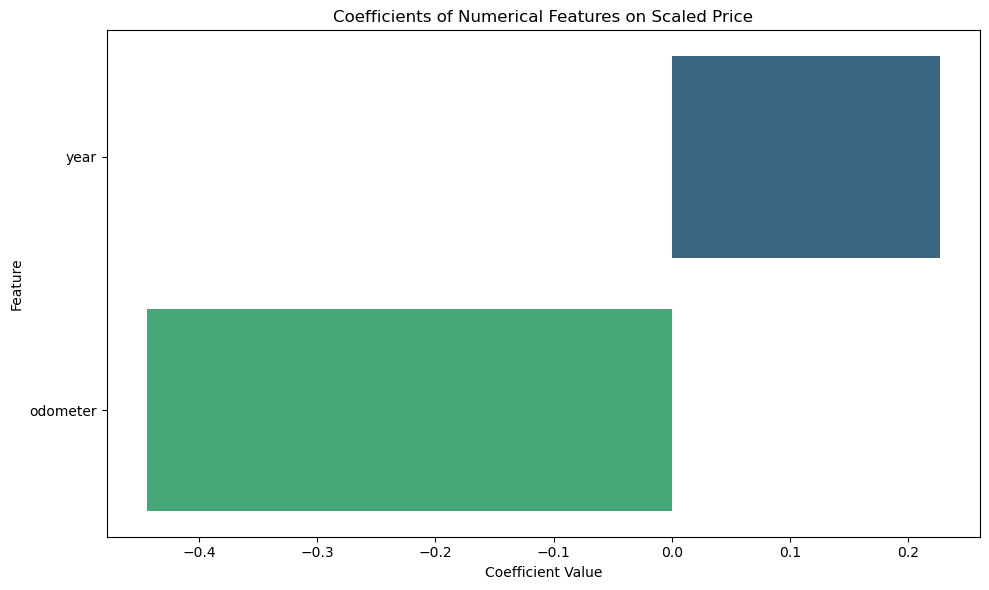

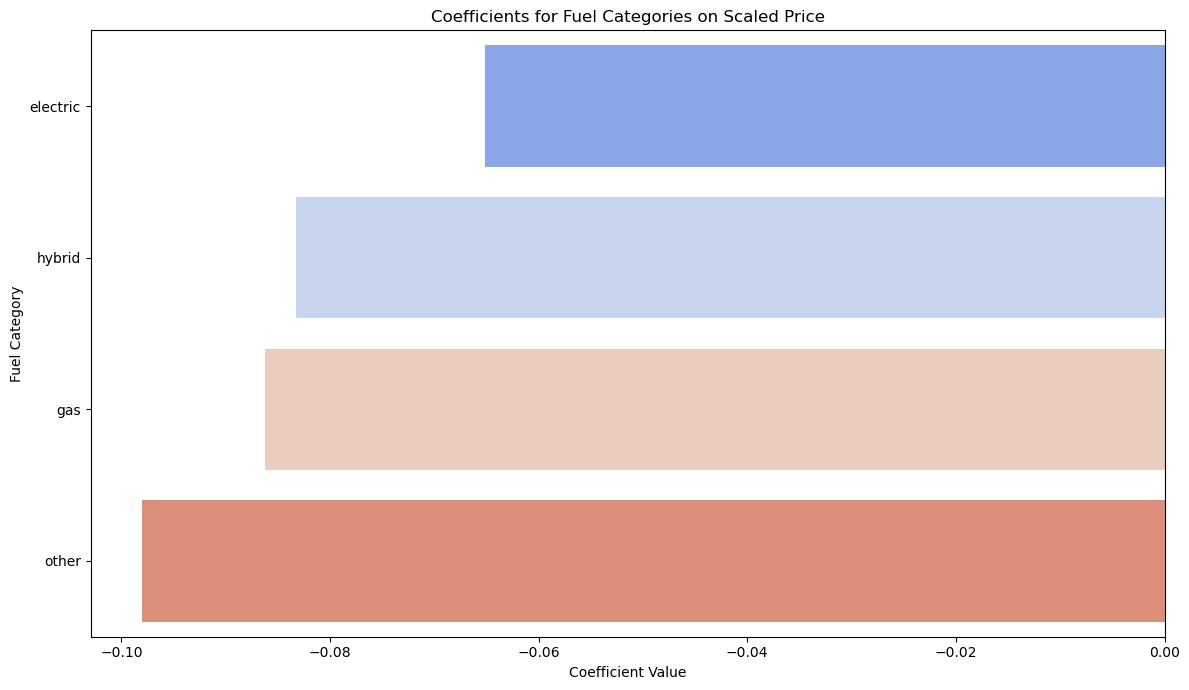

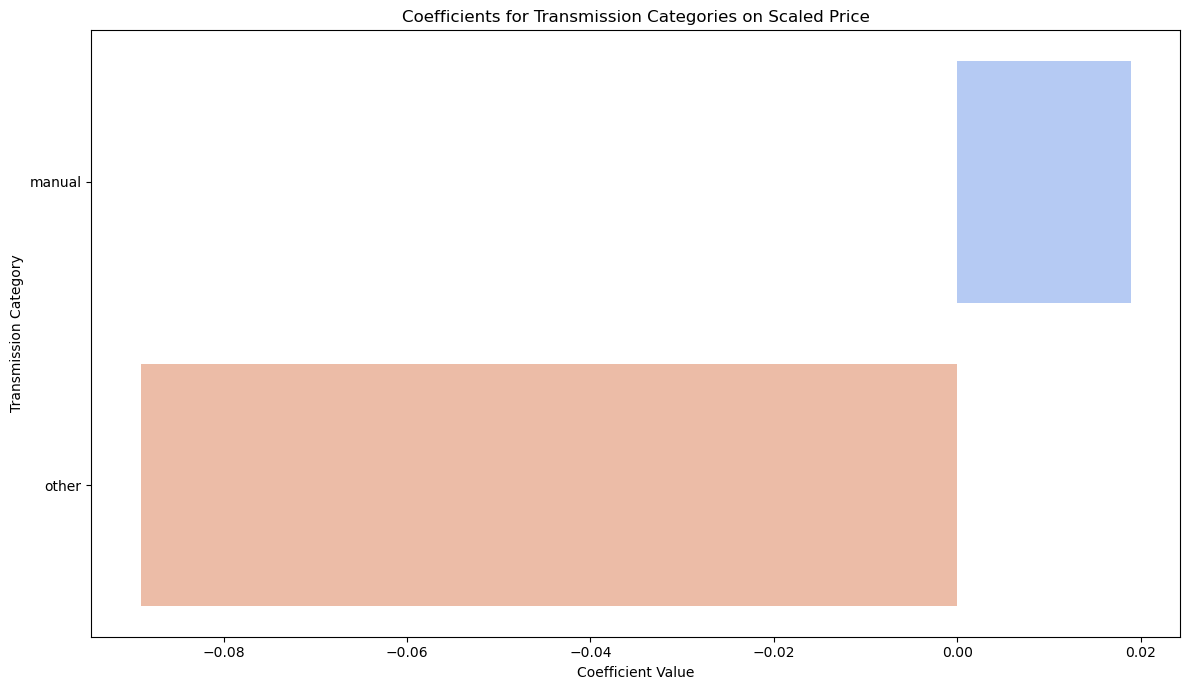

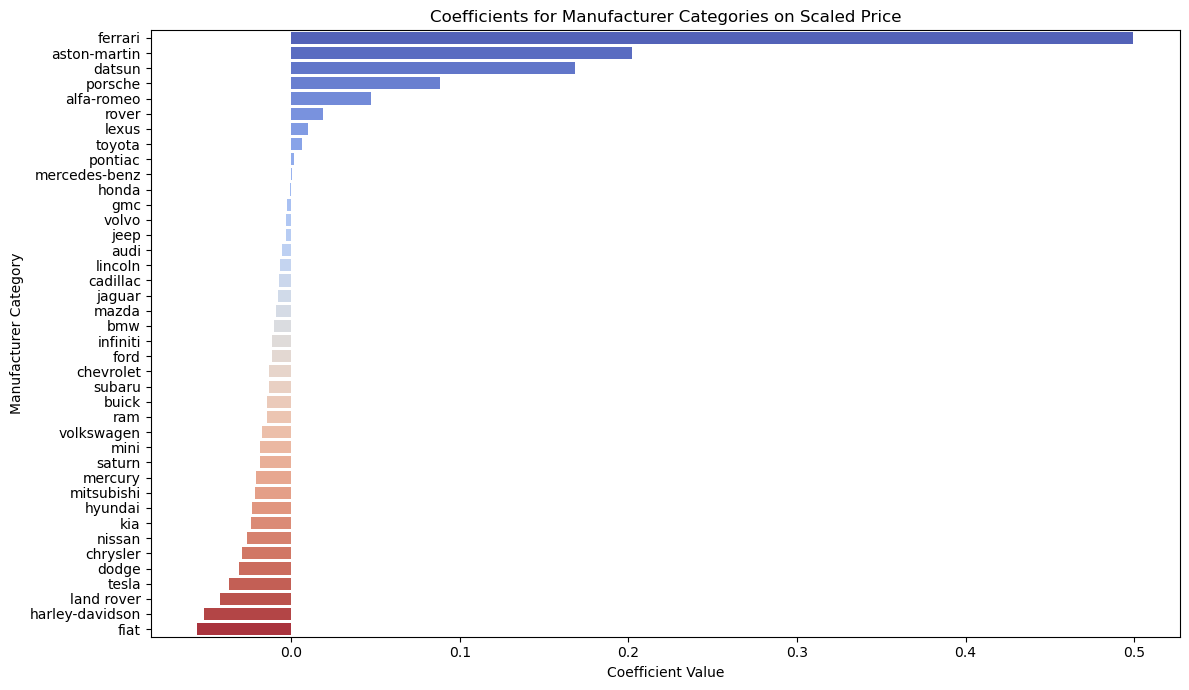

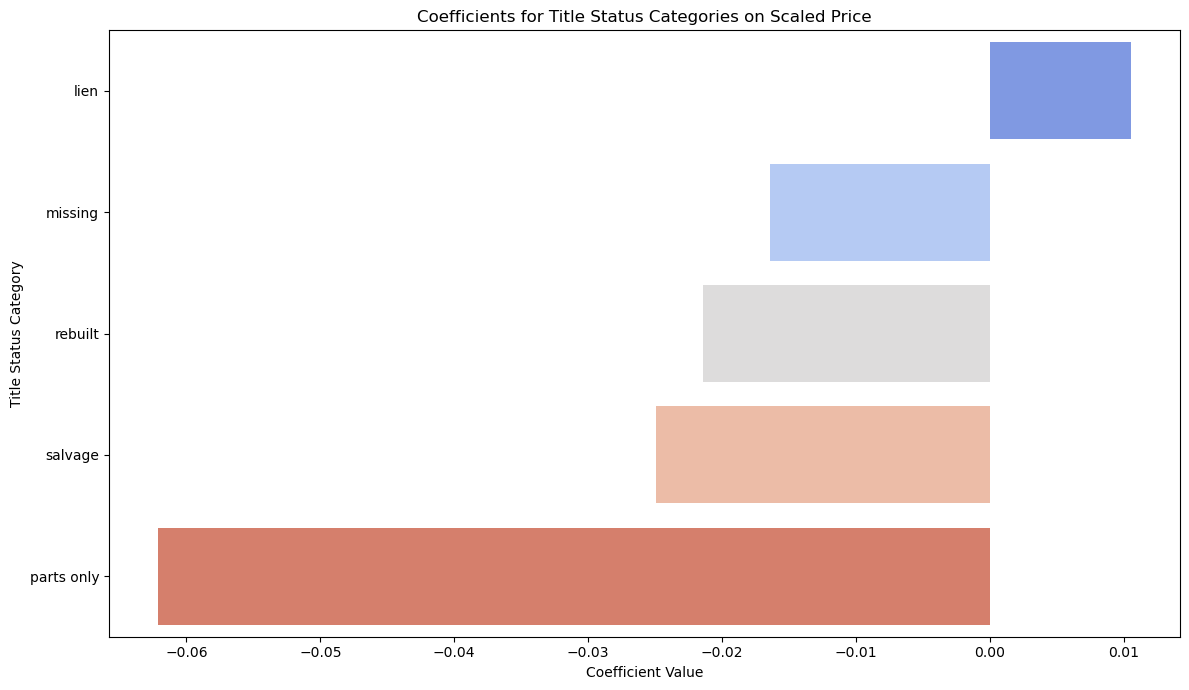

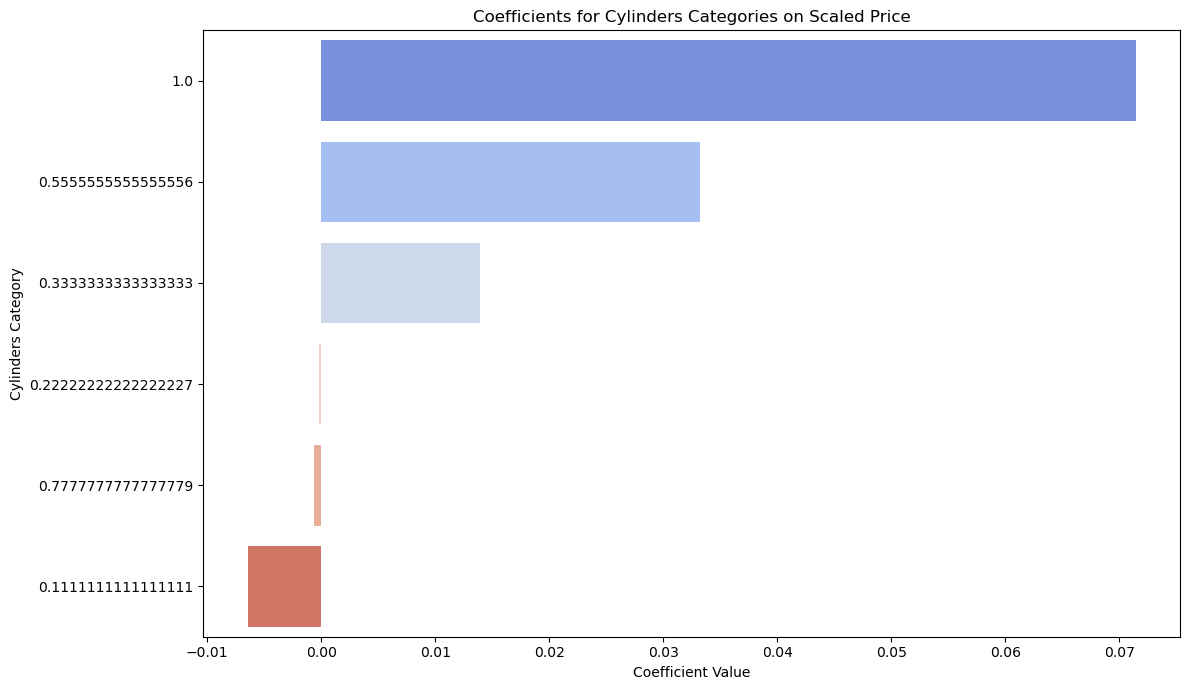

In [123]:
# Define target and categorical features (same as in previous step for consistency)
target_variable = 'price'
categorical_features = ['manufacturer', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'condition', 'title_status', 'cylinders', 'size']

# Create dummy variables for categorical features in scaled data
df_scaled_encoded = pd.get_dummies(df_scaled, columns=categorical_features, drop_first=True)

# Define features (X) and target (y) for scaled data
X_scaled = df_scaled_encoded.drop(columns=[target_variable, 'id', 'region', 'model', 'VIN', 'state'])
y_scaled = df_scaled_encoded[target_variable]

# Split data into training and testing sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train_scaled)

# Get coefficients
coefficients_scaled = pd.DataFrame({'Feature': X_scaled.columns, 'Coefficient': model_scaled.coef_})

# --- Plotting Numerical Feature Coefficients ---
numerical_coefficients = coefficients_scaled[coefficients_scaled['Feature'].isin(['year', 'odometer'])]

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=numerical_coefficients.sort_values(by='Coefficient', ascending=False), palette='viridis')
plt.title('Coefficients of Numerical Features on Scaled Price')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('numerical_coefficients.png')
plt.show()
plt.close()

# --- Plotting Top Categorical Feature Group Coefficients ---
# Group coefficients by original categorical feature name
categorical_coefs_grouped = {}
for col in X_scaled.columns:
    for cat_feat in categorical_features:
        if col.startswith(f"{cat_feat}_"):
            if cat_feat not in categorical_coefs_grouped:
                categorical_coefs_grouped[cat_feat] = []
            categorical_coefs_grouped[cat_feat].append(coefficients_scaled[coefficients_scaled['Feature'] == col]['Coefficient'].iloc[0])

# Calculate average absolute coefficient magnitude for each categorical feature group
average_abs_coefs = {k: pd.Series(v).abs().mean() for k, v in categorical_coefs_grouped.items()}
sorted_categorical_features = sorted(average_abs_coefs.items(), key=lambda item: item[1], reverse=True)

# Select top N categorical feature groups to plot
top_n = 5 # You can adjust this number
top_categorical_features_to_plot = [item[0] for item in sorted_categorical_features[:top_n]]

for cat_feat in top_categorical_features_to_plot:
    # Get all coefficients related to this categorical feature
    coefs_for_plot = coefficients_scaled[coefficients_scaled['Feature'].str.startswith(f"{cat_feat}_")].copy()
    coefs_for_plot['Category'] = coefs_for_plot['Feature'].apply(lambda x: x.replace(f"{cat_feat}_", ""))

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Coefficient', y='Category', data=coefs_for_plot.sort_values(by='Coefficient', ascending=False), palette='coolwarm')
    plt.title(f'Coefficients for {cat_feat.replace("_", " ").title()} Categories on Scaled Price')
    plt.xlabel('Coefficient Value')
    plt.ylabel(f'{cat_feat.replace("_", " ").title()} Category')
    plt.tight_layout()
    plt.savefig(f'{cat_feat}_coefficients.png')
    plt.show()
    plt.close()

<b>Analysis of results: </b>

As seen in the Coefficients of Numerical Features on Scaled Price plot, the year and odometer columns have significant coefficients:

Year: A positive coefficient for year indicates that newer vehicles (higher year values) tend to have higher prices. This is an expected and strong driver of used car prices.

Odometer: A negative coefficient for odometer suggests that vehicles with higher mileage tend to have lower prices. This is also an expected strong driver, as higher mileage typically implies more wear and tear.

Manufacturer: As shown in the Coefficients for Manufacturer Categories on Scaled Price plot, the manufacturer of a vehicle plays a very significant role in determining its price. Brands like 'ferrari' and 'datsun' have very high positive coefficients, indicating that vehicles from these manufacturers tend to command much higher prices compared to the base manufacturer (which is the one that was dropped during one-hot encoding, typically the first alphabetically). Conversely, manufacturers like 'fiat' and 'hyundai' show negative coefficients, implying lower prices relative to the base.

Fuel: The Coefficients for Fuel Categories on Scaled Price plot illustrates the impact of fuel type. Fuel type 'gas' has a higher negative coefficient than 'hybrid' and 'electric', suggesting that vehicles that run on 'gas' are relatively cheaper than 'hybrid' and 'electric'. Hybrid vehicles command higher price than gas and elctric vehicles command the highest price among these three fuel types. 

Transmission: The Coefficients for Transmission Categories on Scaled Price plot shows the coefficients for different transmission types. transmission_manual has a positive coefficient, suggesting that manual transmission vehicles might be priced higher than automatic vehicles (the likely base category, if 'automatic' was dropped). transmission_other has a negative coefficient.

Title Status: As shown in the Coefficients for Title Status Categories on Scaled Price plot, the title_status of a vehicle significantly impacts its price. Categories like 'parts only', 'salvage', and 'rebuilt' have substantial negative coefficients, indicating that vehicles with these title statuses are priced much lower, which is expected due to their compromised condition or legal status.

Cylinders: From the Coefficients for Cylinders Categories on Scaled Price plot, it's evident that the number of cylinders has a notable impact. Vehicles with 12 cylinders have a strong positive coefficient, implying higher prices. Conversely, vehicles with fewer cylinders tend to have negative or smaller positive coefficients.

<b>In summary, the most influential drivers of used car prices, based on this model, are: </b>

1. Vehicle Age/Year: Newer vehicles are more expensive.
2. Odometer Reading: Lower mileage vehicles are more expensive.
3. Manufacturer: Certain brands command significantly higher or lower prices.
4. Fuel Type: Different fuel types have varying impacts on price.
5. Transmission Type: Manual transmissions can influence price positively compared to the base.
6. Title Status: A 'clean' title is crucial for a higher price, while problematic titles significantly decrease value.
7. Cylinders: Higher cylinder counts (e.g., 12 cylinders) are associated with higher prices.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

<b>Primary Findings :</b>

Based on the data and regression model, the following features impact the price of a used car :

1. Year : As seen in the above analysis with co-efficients of year vs price, newer vehicles sell for more. This is a primary determinant, reflecting depreciation over time.

2. Mileage : The odometer reading has a strong negative correlation with price. Vehicles with higher mileage sell for less, due to more wear and tear.

3. Manufacturer: The brand significantly influences pricing. Luxury brands e.g. Ferrari and Datsun show high positive coefficients, indicating their premium pricing in the used car market. Conversely, cheap brands like Fiat and Hyundai exhibit negative coefficients, suggesting they tend to be priced lower.

4. Fuel Type: The Coefficients for Fuel Categories on Scaled Price plot illustrates that fuel type impacts price. For instance, gas cars are cheaper than hybrid and electric cars.

5. Transmission: The Coefficients for Transmission Categories on Scaled Price plot indicates the influence of transmission type. Manual transmissions tend to have a positive impact on price compared to automatic.

6. Title Status: As seen in the Coefficients for Title Status Categories on Scaled Price plot, the vehicle's title status is a critical factor.
Negative Impact: Titles such as 'parts only', 'salvage', and 'rebuilt' significantly decrease a vehicle's value, reflecting the inherent risks and limitations associated with them. A 'clean' title is implicitly associated with higher values.

7. Cylinders: The Coefficients for Cylinders Categories on Scaled Price plot shows that the number of cylinders can affect price. Vehicles with 12 cylinders tend to fetch higher prices, often associated with performance or luxury vehicles. 

<b>Based on these findings, used car dealers can refine their strategies: </b>

Pricing Strategy:
1. Prioritize Age and Mileage: These are the most direct quantitative indicators of value. Newer vehicles with lower mileage can command premium prices.
2. Brand Value: Factor in the manufacturer's reputation and market demand. Vehicles from high-value brands can be priced more aggressively, while those from lower-value brands may require competitive pricing.
3. Title Clarity: Vehicles with clean titles are more valuable and easier to sell. Be cautious when acquiring vehicles with 'salvage' or 'rebuilt' titles, as they will significantly depress prices.
Inventory Management:
1. Targeted Procurement: Focus on acquiring vehicles that align with high-demand features (e.g., popular manufacturers, desirable fuel/transmission types).
2. Diverse Inventory: While focusing on high-value attributes, maintain a diverse inventory to cater to different customer segments and price points.
3. Marketing and Sales:
   - Highlight Key Attributes: Emphasize positive attributes like low mileage, recent year, desirable manufacturer, and clean title in marketing materials.
   - Transparent Disclosure: Be transparent about any factors that negatively impact price, such as higher mileage or problematic title statuses, to build trust with customers.

By leveraging these data-driven insights, used car dealers can make more informed decisions regarding inventory, pricing, and sales strategies in the competitive used car market.